In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/DESI-QA/")
sys.path.append("/home/faoli/programs/desi/desiarc/arc/")
import find_center as fc
from spotfinder import spotfinder


In [530]:
def find_spot(fitsname, fitspath,  
              expected_spot_count=1, 
              regionsname='../regions.reg', 
              verbose=False):
    """
    spotfinder handler
    input:
        fitsname:
        fitspath (str): relative or full path to the folder
        regionsname (str):
        verbose (bool):
    output: 
        centroids (dict): raw output from spotfinder

    """
    import os
    
    assert isinstance(fitsname, str)

    _ifn = f"{fitspath}/{fitsname}"
    if not (os.path.isfile(_ifn)):
        print(f"File not found \n{_ifn}")
#     if expected_spot_count != 1:
#         raise NotImplementedError("This mode wasn't tested here")
    try: 
        sf=spotfinder.SpotFinder(_ifn, expected_spot_count)
        centroids = sf.get_centroids(print_summary = verbose, 
                                     region_file=regionsname)
        if verbose: print(centroids)
    
    except Exception as err: #ignore photo if an error is raised
        print(f"{err}\nWarning: spot not found ")
        inval_number = np.nan
        return {  'peaks': [inval_number], 
                      'x': [inval_number], 
                      'y': [inval_number], 
                   'fwhm': [inval_number], 
                 'energy': [inval_number]} 
    return centroids


def collect_xy(files, picspath):
    # treating for single file
    if isinstance(files, str):
        files = [files]
    x2, y2 = [],[]
    for fullname in files:
        iname = fullname.split('/')[-1]
        _c = find_spot(iname, picspath)
        x2.append(_c['x'])
        y2.append(_c['y'])
    return x2, y2

# Fiducial calibration

TURN ON FIDUCIAL, TURN OFF POSITIONER BACKLIGHT

In [531]:
from astropy.io import fits 
fiducial_pic = "20230217-162739.fits"
fiducial_path = '/home/msdos/DESI-QA/sbigpics/getpic-20230217-162737'
dd = find_spot(fiducial_pic, 
               fiducial_path, 
               regionsname=False, 
               expected_spot_count=4)

Edge hot spot
Edge hot spot
peak = 82780.01526188022 brightness appears out of expected range
peak = 83552.06737042287 brightness appears out of expected range
peak = 74737.42432520037 brightness appears out of expected range
peak = 70380.10144509711 brightness appears out of expected range


(1000.0, 1200.0)

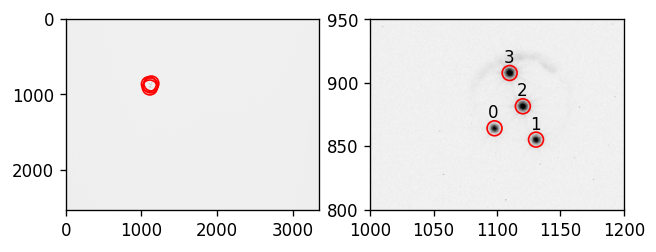

In [532]:
img = fits.getdata(f"{fiducial_path}/{fiducial_pic}")

plt.subplot(121)
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
plt.gca().invert_yaxis()
plt.subplot(122)
plt.gca().invert_yaxis()
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
for pt, (i,j) in enumerate(zip(dd['x'], dd['y'])):
    plt.annotate(pt, xy=(i-5,j+8), xycoords='data')
plt.ylim([800, 950])
plt.xlim(1000, 1200)

In [533]:
cx = np.array(dd['x'])
cy = np.array(dd['y'])
d = lambda i, j: np.hypot(cx[j] -cx[i], cy[j] - cy[i])

# User should MATCH ORDER OF SPOTS
dphys = { (3,2):1,(3,1):2, (3,0):1.6, (2,1):1, (2,0):1,  (1,0):1.2  }
ratioall = np.array([])
dph =  np.array([1, 2, 1.6, 1, 1, 1.2]) # weighting by the distance
pix2mm = np.array([])
for i,j in [(3,2), (3,1), (3,0), (2,1), (2,0), (1,0)]:
    _x = d(i,j)/dphys[(i,j)]
    ratioall = np.append(ratioall, _x)
    pix2mm = np.append(pix2mm, dphys[(i,j)]/d(i,j))
# assert pix2mm
    
print(f"{ratioall.mean():.4f} +/- {np.std(ratioall, ddof=1):.4f}")
mu_mm2pix = (ratioall*dph).sum() /dph.sum()
std_mm2pix = np.sqrt( np.sum(dph* (ratioall-mu_mm2pix)**2)/ ( dph.sum() * (len(dph)-1)/len(dph) ) )

def stats(pix2mm, w):
    # w: dph Physical distance in the model
    N = len(w!=0)
    _mu = np.sum(pix2mm * w)/w.sum()
    _std = np.sum(w * (pix2mm - _mu)**2)/( w.sum() * ((N-1)/N) )
    _std = np.sqrt(_std)
    return _mu, _std

# ------------
# Calibration 
# weighting values based on the (expected) distance size from template
mu1, std1 = stats(pix2mm, dph)
mu2, std2 = stats(pix2mm, np.ones_like(pix2mm))
    
print(f"weighted: {mu_mm2pix:.4f} +/- {std_mm2pix:.4f}" )
print(f"weighted: {mu1:.6f} +/- {std1:.6f}" )
ratioall, (ratioall*dph).sum() /dph.sum(),  #mu2, std2, 1/mu2

28.2450 +/- 0.0165
weighted: 28.2439 +/- 0.0148
weighted: 0.035406 +/- 0.000019


(array([28.23889579, 28.23819404, 28.24605968, 28.23753624, 28.27744879,
        28.23202334]),
 28.24389646164703)

In [534]:
pix2mm =  0.035406 # +/- 0.000019

# Positional Calibration

TURN OFF FIDUCIAL, TURN ON POSITIONER BACKLIGHT

In [535]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')        

In [536]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)
db.tail()

,label,session,mount,move,posid,direction,speed,motor,angle,xpix,ypix,peaks,fwhm
520,xy60,2023-02-17 19:24:56,0,20230217-193605,4852,ccw,cruise,phi,26.220457,2102.450087,832.839475,72528.1153,3.2608
521,xy60,2023-02-17 19:24:56,0,20230217-193617,4852,ccw,cruise,phi,9.432913,2101.029312,873.200247,72848.5657,3.2484
522,xy60,2023-02-17 19:24:56,0,20230217-193628,4852,ccw,cruise,phi,-3.931835,2099.840319,911.193117,73464.2242,3.2511
523,xy60,2023-02-17 19:24:56,0,20230217-193640,4852,cw,cruise,phi,9.500795,2098.633088,949.330563,73773.8229,3.2545
524,xy60,2023-02-17 19:24:56,0,20230217-193653,4852,cw,cruise,phi,26.286592,2096.613846,988.594651,73620.3463,3.2920


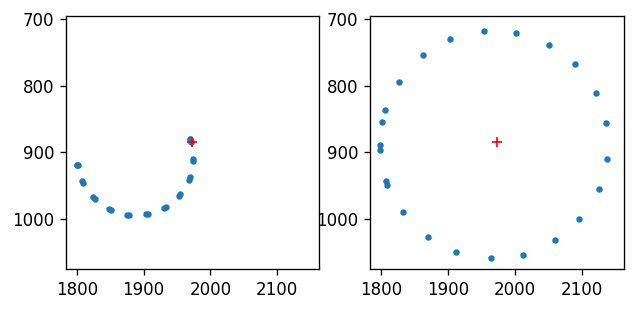

In [537]:
m2 = query_time(db, datemin='2023-02-17')
m2 = (m2) & ( db['label'].str.contains('arcphi15') )
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], s=8)
setplot(1973, 885, 190)

plt.subplot(122)

m1 = query_time(db, datemin='2023-02-17')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')

plt.scatter('xpix', 'ypix', data=db[m1], s=8)
setplot(1973, 885, 190)


In [362]:
def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [363]:
db['xmm'] = db['xpix']* pix2mm
db['ymm'] = db['ypix']* pix2mm


66.8139270919831 32.121232165501 3.081499577060011


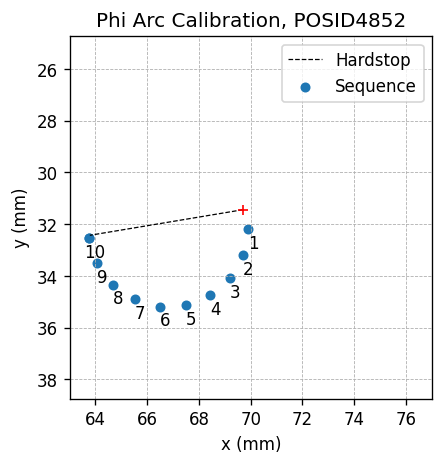

In [525]:
m3 = query_time(db, datemin='2023-02-17') & ( db['label'].str.contains('arcphi15') ) & ( db['direction']==('cw') )

pix2mm = 0.035406
xc0, yc0 = 69.7024, 31.4413# (1973*pix2mm, 885 *pix2mm)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m3])]
print(xc2,yc2,R2)

xline = [xc0,xc0+(6*np.cos(-166.67))]
yline = [yc0,yc0+(6*np.sin(-166.67))]

steps = list(range(1,len(db[m3][1:-1])))

fig, ax = plt.subplots()

for (xi,yi,i) in zip(db[m3]['xmm'][1:-1],db[m3]['ymm'][1:-1],steps):
    plt.text(xi+0.2,yi+.2,i,va='top',ha='center',size=10)

#plt.figure(figsize=(4,4))
plt.scatter('xmm', 'ymm', data=db[m3][1:-1], s=25,label='Sequence')
plt.plot(xline,yline,color='k',linestyle='--',label='Hardstop',linewidth=0.75)
setplot(xc0, yc0,7)
plt.title('Phi Arc Calibration, POSID4852')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.legend()
plt.grid(linestyle='--',linewidth=0.5)
ax.set_box_aspect(1)
plt.show()

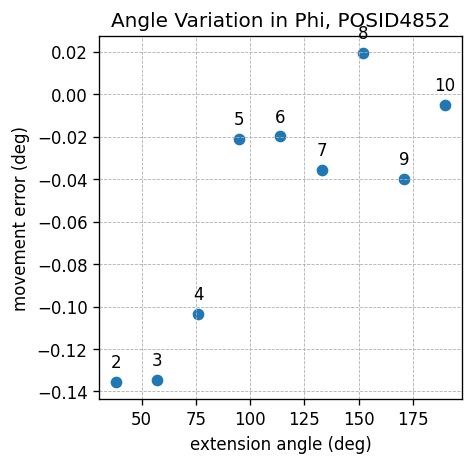

-0.05286461614315188


In [518]:
# pix2mm = 0.035354
# xc0, yc0 = (1973*pix2mm, 885 *pix2mm)
r = (171+20)*pix2mm
xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m3])]

xytuples = [(i,j) for i, j in zip(db[m3]['xmm'][1:-2].values, db[m3]['ymm'][1:-2].values)]

angs = np.array([angle_between((xc2, yc2), xytuples[i], xytuples[i+1]) for i in range(len(xytuples) -1 ) ] )

fig, ax = plt.subplots()
phi_angles = np.arange(2*(15+2*1.995),(len(angs)+2)*(15+2*1.995),(15+2*1.995))

for (xi,yi,i) in zip(phi_angles,angs-(15+2*1.995),steps):
    plt.text(xi,yi+0.005,i+1,va='bottom',ha='center',size=10)

plt.scatter(phi_angles,angs-(15+2*1.995))
plt.title("Angle Variation in Phi, POSID4852")
plt.xlabel('extension angle (deg)')
plt.ylabel('movement error (deg)')
plt.grid(linestyle='--',linewidth=0.5)

ax.set_box_aspect(1)
plt.show()
print(np.average(angs-(15+2*1.995)))


363    0.001267
364    0.005043
365    0.005707
366    0.003582
367   -0.000043
368   -0.002022
369   -0.004553
370   -0.005524
371   -0.006509
dtype: float64


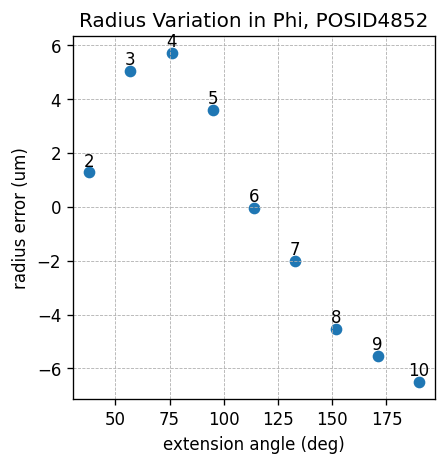

-0.33903156214738


In [512]:
DRphi = np.hypot(db['xmm'][m3][1:-3] - xc2, db['ymm'][m3][1:-3] - yc2)
print(DRphi-R2)
#plt.hist((DRphi - R2)/R2, histtype='step') # it's 10 times what we saw for theta in the metric notebook 

fig, ax = plt.subplots()
phi_angles = np.arange(2*(15+2*1.995),(len(DRphi)+2)*(15+2*1.995),(15+2*1.995))

for (xi,yi,i) in zip(phi_angles,(DRphi-R2)*1000,steps):
    plt.text(xi,yi+.1,i+1,va='bottom',ha='center',size=10)
    
plt.scatter(phi_angles,(DRphi-R2)*1000)
plt.title("Radius Variation in Phi, POSID4852")
plt.xlabel('extension angle (deg)')
plt.ylabel('radius error (um)')
plt.grid(linestyle='--',linewidth=0.5)

ax.set_box_aspect(1)
plt.show()

print(np.average((DRphi-R2)*1000))


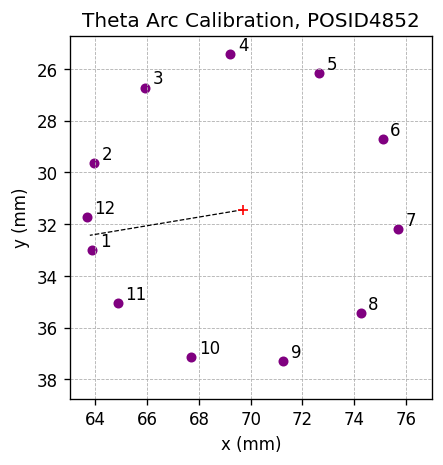

In [526]:
m4 = query_time(db, datemin='2023-02-17') & ( db['label'].str.contains('arcth30') ) & ( db['direction']==('cw') )
xc0, yc0, R = [i*pix2mm for i in fc.get_circle(db[m4])]

m4b = query_time(db, datemin='2023-02-17') & ( db['label'].str.contains('arcth30') ) & ( db['direction']==('ccw') )
m4t = query_time(db, datemin='2023-02-17') & ( db['label'].str.contains('arcth30') )

# pix2mm = 0.035354
# xc0, yc0 = (1973*pix2mm, 885 *pix2mm)
# xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m4])]
# print(xc2,yc2,R2)

xline = [xc0,xc0+(6*np.cos(-166.67))]
yline = [yc0,yc0+(6*np.sin(-166.67))]

steps = list(range(1,len(db[m4])))

fig, ax = plt.subplots()

for (xi,yi,i) in zip(db[m4]['xmm'],db[m4]['ymm'],steps):
    plt.text(xi+0.3,yi,i,va='bottom',ha='left',size=10)

plt.plot(xline,yline,color='k',linestyle='--',label='Hardstop',linewidth=0.75)
plt.scatter('xmm', 'ymm', data=db[m4][:-1], s=25,label='Sequence',c='purple')
setplot(xc0, yc0,7)
plt.title('Theta Arc Calibration, POSID4852')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.legend(loc=(1.04,0))
plt.grid(linestyle='--',linewidth=0.5)
ax.set_box_aspect(1)
plt.show()

In [470]:
xytup = lambda mask: [(i,j) for i, j in zip(db[mask]['xmm'].values, db[mask]['ymm'].values)]
xy2ang = lambda center, xytuples: np.array([angle_between(center, xytuples[i], xytuples[i+1]) 
                                for i in range(len(xytuples) -1 ) ] )


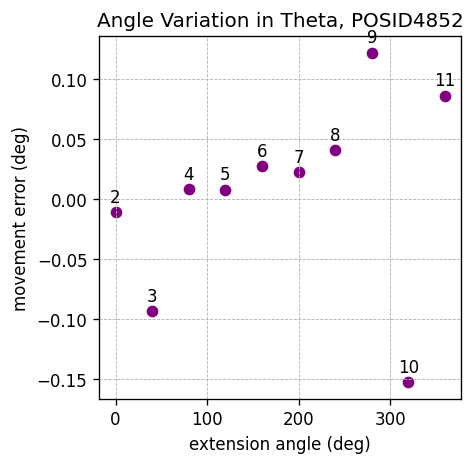

0.005696278535749855


In [516]:
#pix2mm = 0.035354
#xc0, yc0 = (1973*pix2mm, 885 *pix2mm)
r = (171+20)*pix2mm
# xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m3])]
# plt.figure(dpi=100)
# db['xmm'] = db['xpix']* pix2mm
# db['ymm'] = db['ypix']* pix2mm

steps = list(range(1,len(db[m4])))

xytuples = [(i,j) for i, j in zip(db[m4]['xmm'].values, db[m4]['ymm'].values)]
xyccw = xytup(m4b)
xyt = xytup(m4t)
angccw = xy2ang((xc0,yc0), xyccw)

angs = np.array([angle_between((xc0, yc0), xytuples[i], xytuples[i+1]) for i in range(len(xytuples) -1 ) ] )
angs = angs[1:-1]

fig, ax = plt.subplots()
theta_angles = np.linspace(0,360,len(angs))


plt.scatter(theta_angles, angs-(30+2*1.995),c='purple')

for (xi,yi,i) in zip(theta_angles,angs-(30+2*1.995),steps):
    plt.text(xi,yi+.005,i+1,va='bottom',ha='center',size=10)

# plt.plot(angs-34)
# plt.plot(angccw-34)

plt.title("Angle Variation in Theta, POSID4852")
plt.xlabel('extension angle (deg)')
plt.ylabel('movement error (deg)')

plt.grid(linestyle='--',linewidth=0.5)

ax.set_box_aspect(1)
plt.show()

print(np.average(angs-(30+2*1.995)))

388   -0.000440
389    0.001321
390    0.001172
391   -0.000192
392   -0.000990
393   -0.000782
394    0.000014
395    0.000992
396    0.001685
397   -0.001034
dtype: float64


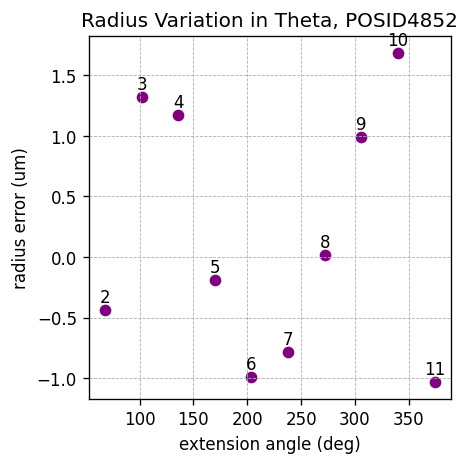

In [507]:
DRtheta = np.hypot(db['xmm'][m4][1:-2] - xc0, db['ymm'][m4][1:-2] - yc0)
print(DRtheta-R)
#plt.hist((DRphi - R2)/R2, histtype='step') # it's 10 times what we saw for theta in the metric notebook 

fig, ax = plt.subplots()

theta_angles = np.arange(2*(30+2*1.995),(len(DRtheta)+2)*(30+2*1.995),(30+2*1.995))

for (xi,yi,i) in zip(theta_angles,(DRtheta-R)*1000,steps):
    plt.text(xi,yi+0.03,i+1,va='bottom',ha='center',size=10)
    
plt.scatter(theta_angles,(DRtheta-R)*1000,c='purple')
plt.title("Radius Variation in Theta, POSID4852")
plt.xlabel('extension angle (deg)')
plt.ylabel('radius error (um)')
plt.grid(linestyle='--',linewidth=0.5)
ax.set_box_aspect(1)
plt.show()

In [538]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4}, R2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")

69.70240066686817 31.441310814856173 6.040776547566441
66.81557596996126 32.124330022730454 3.0790803167305896
R1: 2.967, R2: 3.079 mm
xc, yc: 69.70240066686817, 31.441310814856173 mm
pix2mm 0.035406


# UPDATE THE CODE WITH THE VALUES ABOVE

# xy test

In [539]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)

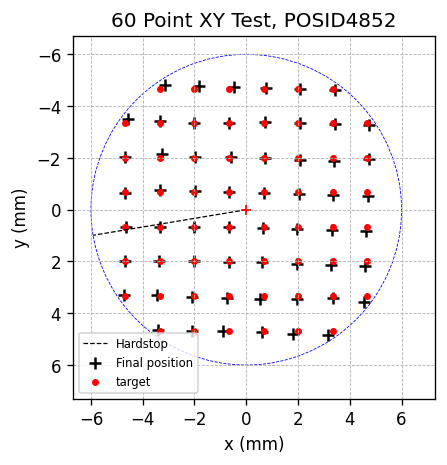

In [596]:
label = 'xy60'
mxy = db["label"].str.contains(label)
mxy = (mxy) & (query_time(db, datemin='2023-02-17 19:00:00'))
dbxy = db[['xpix','ypix']][mxy].reindex()
dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)

xytgt = pd.read_csv("../movetables/XY_60.txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

xline = [0,(6*np.cos(-166.67))]
yline = [0,(6*np.sin(-166.67))]

fig, ax = plt.subplots()
plt.plot(xline,yline,color='k',linestyle='--',label='Hardstop',linewidth=0.75)
circle = plt.Circle((0,0),6,fill=False,linestyle='--',linewidth=0.5,color = "blue",label="Max range")
ax.add_artist(circle)
plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=50, label='Final position')#c=dbxy.index,cmap='Blues', edgecolors='b')
plt.scatter('xpos', 'ypos', data=xytgt, c='r', marker='o', s=10, label='target')

plt.title("60 Point XY Test, POSID4852")
plt.legend(loc='best', fontsize=7)
setplot(0, 0,7)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid(linestyle='--',linewidth=0.5)
plt.show()


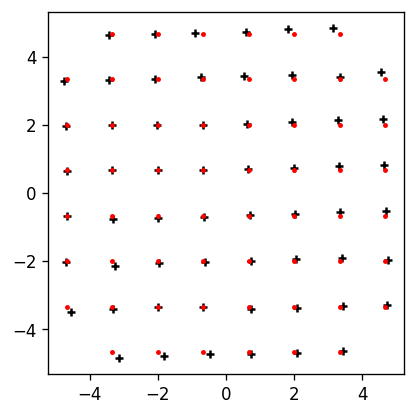

In [166]:
label = 'xy60'
mxy = db["label"].str.contains(label)
mxy = (mxy) & (query_time(db, datemin='2023-02-17 19:00:00'))
dbxy = db[['xpix','ypix']][mxy].reindex()
dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)

# xytgt = pd.read_csv("../movetables/XY_60.txt", sep=" ", header=None)
# xytgt.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=20)#c=dbxy.index,cmap='Blues', edgecolors='b')
# # plt.colorbar()
plt.scatter('xpos', 'ypos', data=xytgt, c='r', marker='.', s=15, label='target')
# plt.title(r"xy, 60 points, no creep correction")
# plt.xlim(-7, +7)
# plt.ylim(+7, -7)
# plt.xlabel('xpos (mm)')
# plt.ylabel('ypos (mm)')
plt.gca().set_aspect('equal')
# plt.legend(loc='best', fontsize=7)


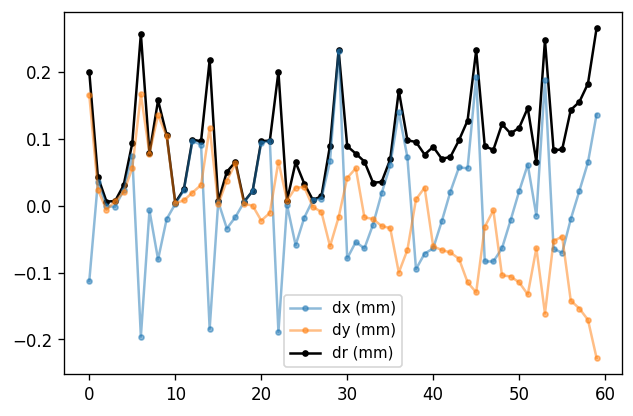

Text(0.5, 0, '$\\delta r \\;(mm)$')

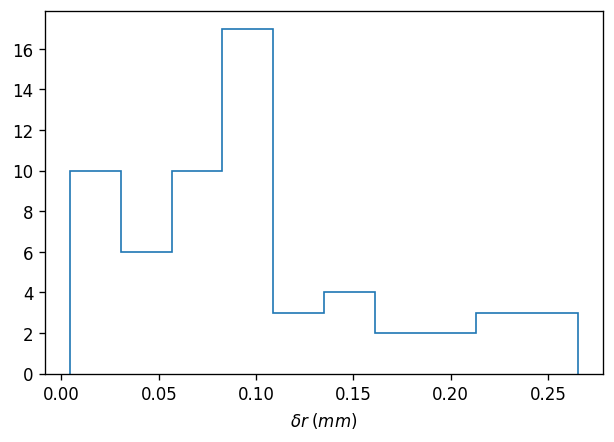

In [167]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')
plt.xlabel('$\delta r \;(mm)$')

Max arrow length = 265.3 um


Text(0, 0.5, 'y (mm)')

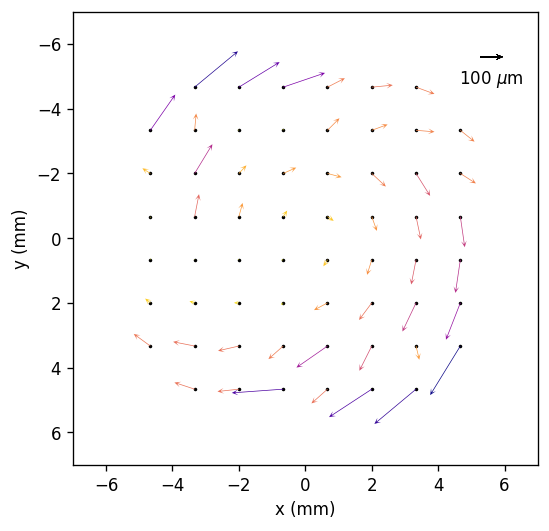

In [600]:
# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))

label = 'xy60'
xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt)
v = 1e3 * (ypos - yt)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=100
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_xlim(-7,7)
ax.set_ylim(7,-7)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

